In [27]:
from gurobipy import Model, GRB, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx  
import random
import numpy as np
import pandas as pd
from scipy.stats import norm

### **Arc Capacity Distribution**
Assume that the correlation among all arc capacities is 0.5

In [51]:
# Set arc information
arc_info = {
    "Arc #": ["1, 2", "3, 4", "5, 6", "7, 8", "9, 10"],
    "Lower bound": [10, 10, 5, 10, 10],
    "Upper bound": [20, 20, 10, 20, 20],
}
arc_df = pd.DataFrame(arc_info)

# Set correlation matrix: Correlation between arcs set to 0.5
num_arcs = len(arc_df)
corr_matrix = np.full((num_arcs, num_arcs), 0.5)  
np.fill_diagonal(corr_matrix, 1) 

# 1. Generate standard normal samples
num_samples = 5000
mean = np.zeros(num_arcs)
std_normal_samples = np.random.multivariate_normal(mean, corr_matrix, size=num_samples)

# 2. Transform to uniform distribution
uniform_samples = np.zeros_like(std_normal_samples)
for i in range(num_arcs):
    lower = arc_df.loc[i, "Lower bound"]
    upper = arc_df.loc[i, "Upper bound"]
    uniform_samples[:, i] = lower + (upper - lower) * norm.cdf(std_normal_samples[:, i])

# 3. Calculate mean and standard deviation for each arc
means = uniform_samples.mean(axis=0)
std_devs = uniform_samples.std(axis=0)

# Organize results into a DataFrame
results = pd.DataFrame({
    "Arc #": arc_df["Arc #"],
    "Mean": means,
    "Standard Deviation": std_devs,
})

# Print results
print(results)

   Arc #       Mean  Standard Deviation
0   1, 2  15.053352            2.854469
1   3, 4  15.048917            2.882340
2   5, 6   7.520903            1.452187
3   7, 8  15.041577            2.886459
4  9, 10  15.052937            2.912252


# **MCNF Decision making**
### **Network Topology**


Commodity: k1
  Shortest distance: 28.28 km
  Maximum allowable time: 17.39 minutes
  Maximum allowable distance: 43.18 km

Commodity: k2
  Shortest distance: 20.0 km
  Maximum allowable time: 14.05 minutes
  Maximum allowable distance: 34.90 km

Commodity: k3
  Shortest distance: 14.14 km
  Maximum allowable time: 11.69 minutes
  Maximum allowable distance: 29.04 km

Commodity: k4
  Shortest distance: 14.14 km
  Maximum allowable time: 11.69 minutes
  Maximum allowable distance: 29.04 km


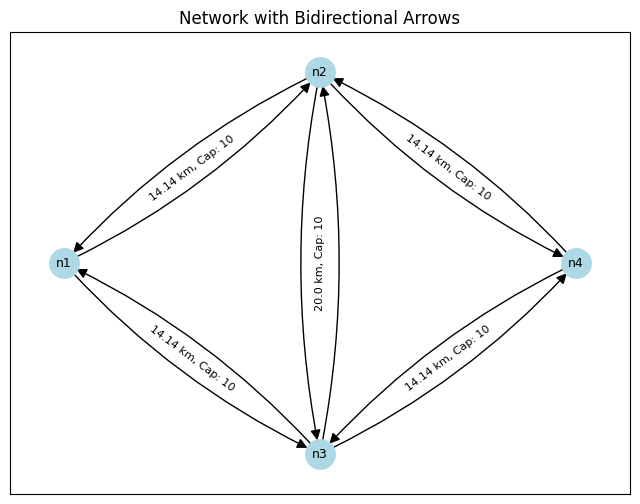

In [55]:
nodes = {
    "n1": (0, 0),
    "n2": (10, 10),
    "n3": (10, -10),
    "n4": (20, 0)
}

edges = {
    'e1': ['n1', 'n2'],
    'e2': ['n1', 'n3'],
    'e3': ['n2', 'n3'],
    'e4': ['n2', 'n4'],
    'e5': ['n3', 'n4']
}

arc_counter = 1
arcs = []
for edge in edges.values():
    for u, v in [edge, edge[::-1]]:
        arcs.append((arc_counter, (u, v)))
        arc_counter += 1    # Consider bi-directional arcs

def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)
arc_distance = {edge: euclidean_distance(edge[0], edge[1]) for _, edge in arcs}



demand = {
    'k1': {'origin': 'n1', 'destination': 'n4', 'amount': 18},
    'k2': {'origin': 'n2', 'destination': 'n3', 'amount': 5},
    'k3': {'origin': 'n1', 'destination': 'n3', 'amount': 7},  
    'k4': {'origin': 'n3', 'destination': 'n4', 'amount': 6}   
}



G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)
for _, (u, v) in arcs:  
    distance = arc_distance[(u, v)]
    capacity = arc_capacity[(u, v)]
    G.add_edge(u, v, weight=distance, capacity=capacity)



# Plot the network
plt.figure(figsize=(8, 6))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=450, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=[edge for _, edge in arcs], 
    arrowstyle='-|>',
    arrowsize=15,
    connectionstyle='arc3,rad=0.1',
    min_target_margin=10,
    min_source_margin=10
)
edge_labels = {edge: f"{arc_distance[edge]} km, Cap: {arc_capacity[edge]}" for _, edge in arcs}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Network with Bidirectional Arrows")
plt.show()

### **MCNF system function**

In [73]:
def MCNF_systemfunc(comps_st, edges, arcs, arc_capacity, demand, arc_distance, max_distance):
    from gurobipy import Model, GRB, quicksum

    # Create Gurobi model
    model = Model("Network Flow Optimization")

    # Define variables
    flow = {}
    unmet_demand = {}
    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            # Determine capacity based on component state
            capacity = arc_capacity.get((i, j), 0) * comps_st[arcs.index((i, j))]
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize the percentage of unmet demand relative to total demand
    total_demand = sum(info['amount'] for info in demand.values())
    model.setObjective(
        (quicksum(unmet_demand[k] for k in demand) / total_demand) * 100, GRB.MINIMIZE
    )
    
    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity.get((i, j), 0))

    # Constraint 3: Distance limits// TODO: D_k 수정함
    avg_velo = 149
    for commodity, info in demand.items():
        shortest_distance = nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight')
        max_allowable_time = (shortest_distance * 60) / avg_velo + 6  # 6 minutes extra
        max_distance = max_allowable_time * avg_velo / 60

        print(f"\nCommodity: {commodity}")
        print(f"  Shortest distance: {shortest_distance} km")
        print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
        print(f"  Maximum allowable distance: {max_distance:.2f} km")

    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get((i, j), 0) * flow[k, i, j] for i, j in arcs)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == origin)
        model.addConstr(distance_expr <= max_distance * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        unmet_demand_percentage = model.objVal 
        flows = {
            k: {arc: flow[k, arc[0], arc[1]].X for arc in arcs} for k in demand
        }
        return unmet_demand_percentage, flows
    else:
        return None, None

### **[Outerloop] Capacity with Uncertainty**

In [72]:
comps_st = {0: 1, 1: 1, 2: 1, 3: 0, 4: 1}  #// FIXME: OuterLoop MCS

# Arc parameters: Mean and Standard Deviation
arc_params = {
    "1, 2": (15.053352, 2.854469),
    "3, 4": (15.048917, 2.882340),
    "5, 6": (7.520903, 1.452187),
    "7, 8": (15.041577, 2.886459),
    "9, 10": (15.052937, 2.912252)
}

# Function to generate random capacities
def generate_arc_capacities(arc_params, num_samples=1):
    arc_capacities = {}
    for arc, (mean, std) in arc_params.items():
        lower_bound = mean - (std * np.sqrt(3))  # Uniform distribution lower bound
        upper_bound = mean + (std * np.sqrt(3))  # Uniform distribution upper bound
        arc_capacities[arc] = np.random.uniform(lower_bound, upper_bound, num_samples)
    return arc_capacities

# Generate random capacities
arc_capacity = generate_arc_capacities(arc_params, num_samples=1)   #// TODO: OuterLoop MCS
for arc, capacities in arc_capacity.items():
    print(f"Arc {arc} Capacity: {capacities}")


# Operate MCNF system function
unmet_percentage, flows = MCNF_systemfunc(
    comps_st=comps_st,
    edges=edges,
    arcs=arcs,
    arc_capacity=arc_capacity,
    demand = demand,
    arc_distance=arc_distance,
    max_distance=max_distance
)

if unmet_percentage is not None:
    print(f"Unmet Demand Percentage: {unmet_percentage:.2f}%")
    print("Flow Allocation:")
    for k, flow_dict in flows.items():
        print(f"  Commodity {k}:")
        for arc, flow_value in flow_dict.items():
            if flow_value > 0:
                print(f"    Flow on {arc}: {flow_value:.2f}")
else:
    print("Optimization failed or infeasible.")

Arc 1, 2 Capacity: [18.93261987]
Arc 3, 4 Capacity: [14.51459377]
Arc 5, 6 Capacity: [7.5035729]
Arc 7, 8 Capacity: [10.37529909]
Arc 9, 10 Capacity: [14.48294046]
